In [12]:
from judo_footage_analysis.utils import get_spark
from pyspark.sql import functions as F

root = "/cs-share/pradalier/tmp/judo"

spark = get_spark(cores=4, mem="1g")
spark

24/04/05 16:01:34 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
! ls {root}/data/annotations

combat-phase-at-2024-04-05-12-54-ebac918e.json
entity-detection-2024-03-19
entity-detection-at-2024-04-05-12-52-6eba090e.json
match-classification-at-2024-04-05-12-47-2a810013.json
old


In [8]:
df = spark.read.json(
    f"{root}/data/annotations/*.json",
    multiLine=True,
)
df.printSchema()
df.show(n=1, vertical=True, truncate=80)
df.count()

root
 |-- annotations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- completed_by: long (nullable = true)
 |    |    |-- created_at: string (nullable = true)
 |    |    |-- draft_created_at: string (nullable = true)
 |    |    |-- ground_truth: boolean (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- import_id: string (nullable = true)
 |    |    |-- last_action: string (nullable = true)
 |    |    |-- last_created_by: string (nullable = true)
 |    |    |-- lead_time: double (nullable = true)
 |    |    |-- parent_annotation: string (nullable = true)
 |    |    |-- parent_prediction: long (nullable = true)
 |    |    |-- project: long (nullable = true)
 |    |    |-- result: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- from_name: string (nullable = true)
 |    |    |    |    |-- id: string (nullable = true)
 |    |    |    |    |-- image_rotation: long (null

3987

In [9]:
df.groupBy("project").count().show()

+-------+-----+
|project|count|
+-------+-----+
|      2| 1651|
|      1| 2314|
|     16|   22|
+-------+-----+



In [19]:
exploded = df.select(F.explode("annotations")).select("col.*")
exploded.show(n=1, vertical=True, truncate=80)

-RECORD 0---------------------------------------------------------------------------------------------
 completed_by      | 1                                                                                
 created_at        | 2024-02-15T17:06:11.229378Z                                                      
 draft_created_at  | 2024-02-15T17:06:01.361688Z                                                      
 ground_truth      | false                                                                            
 id                | 2424                                                                             
 import_id         | NULL                                                                             
 last_action       | NULL                                                                             
 last_created_by   | NULL                                                                             
 lead_time         | 24.803                                              

In [20]:
exploded.groupBy("completed_by", "project").count().orderBy(
    "completed_by", "project"
).show()

+------------+-------+-----+
|completed_by|project|count|
+------------+-------+-----+
|           1|      1| 1076|
|           1|      2|  857|
|           1|     16|   22|
|           3|      1|   39|
|           3|      2|  301|
|           4|      1| 1199|
|           4|      2|  493|
+------------+-------+-----+



In [22]:
exploded.drop("result").printSchema()

root
 |-- completed_by: long (nullable = true)
 |-- created_at: string (nullable = true)
 |-- draft_created_at: string (nullable = true)
 |-- ground_truth: boolean (nullable = true)
 |-- id: long (nullable = true)
 |-- import_id: string (nullable = true)
 |-- last_action: string (nullable = true)
 |-- last_created_by: string (nullable = true)
 |-- lead_time: double (nullable = true)
 |-- parent_annotation: string (nullable = true)
 |-- parent_prediction: long (nullable = true)
 |-- project: long (nullable = true)
 |-- result_count: long (nullable = true)
 |-- task: long (nullable = true)
 |-- unique_id: string (nullable = true)
 |-- updated_at: string (nullable = true)
 |-- updated_by: long (nullable = true)
 |-- was_cancelled: boolean (nullable = true)



In [29]:
for row in exploded.select("project").distinct().collect():
    print(row)
    exploded.where(F.col("project") == row.project).select(
        "lead_time"
    ).describe().show()

Row(project=2)
+-------+------------------+
|summary|         lead_time|
+-------+------------------+
|  count|              1651|
|   mean|10.369197456087232|
| stddev|13.733286326242641|
|    min|             0.557|
|    max|           199.243|
+-------+------------------+

Row(project=1)
+-------+------------------+
|summary|         lead_time|
+-------+------------------+
|  count|              2314|
|   mean|2.9380553154710407|
| stddev| 38.08231107078979|
|    min|             0.253|
|    max|          1819.295|
+-------+------------------+

Row(project=16)
+-------+------------------+
|summary|         lead_time|
+-------+------------------+
|  count|                22|
|   mean|166.76213636363633|
| stddev|125.43894745948096|
|    min|             3.181|
|    max|506.30000000000007|
+-------+------------------+



In [114]:
result_exploded = exploded.select("*", F.explode("result")).select("*", "col.*")
# result_exploded.printSchema()
task_annotations = result_exploded.select(
    "project", "completed_by", "lead_time", "updated_at", "unique_id", "origin"
)
task_annotations.show()

+-------+------------+---------+--------------------+--------------------+------------------+
|project|completed_by|lead_time|          updated_at|           unique_id|            origin|
+-------+------------+---------+--------------------+--------------------+------------------+
|      2|           1|   24.803|2024-02-15T17:06:...|6fd03a2d-a072-48e...|        prediction|
|      2|           1|   24.803|2024-02-15T17:06:...|6fd03a2d-a072-48e...|        prediction|
|      2|           1|   24.803|2024-02-15T17:06:...|6fd03a2d-a072-48e...|prediction-changed|
|      2|           4|   36.335|2024-02-20T12:58:...|533ae198-4bc7-4bd...|        prediction|
|      2|           4|   36.335|2024-02-20T12:58:...|533ae198-4bc7-4bd...|        prediction|
|      2|           4|   36.335|2024-02-20T12:58:...|533ae198-4bc7-4bd...|prediction-changed|
|      2|           1|    6.796|2024-02-15T17:12:...|f2b8e5d0-5840-42e...|        prediction|
|      2|           1|    6.796|2024-02-15T17:12:...|f2b8e5d

In [115]:
task_annotations.groupBy("project").count().show()

+-------+-----+
|project|count|
+-------+-----+
|      2| 3473|
|      1| 2311|
|     16|   63|
+-------+-----+



In [116]:
task2 = task_annotations.where("project = 2")
task2.groupBy("unique_id").count().describe().show()

+-------+--------------------+------------------+
|summary|           unique_id|             count|
+-------+--------------------+------------------+
|  count|                1328|              1328|
|   mean|                NULL| 2.615210843373494|
| stddev|                NULL|0.7698015192393763|
|    min|0017a8e5-b0b0-4fe...|                 1|
|    max|ffddd5e4-dde6-4a4...|                 4|
+-------+--------------------+------------------+



In [117]:
task2.groupBy("origin").count().show()

+------------------+-----+
|            origin|count|
+------------------+-----+
|        prediction| 2199|
|            manual|  210|
|prediction-changed| 1064|
+------------------+-----+



In [118]:
taskdf = (
    task2.groupBy("unique_id")
    .agg(F.first("updated_at").alias("updated_at"))
    .orderBy("updated_at")
    # iso-date to seconds since epoch
    .withColumn("updated_at", F.col("updated_at").cast("timestamp"))
    # truncate to hour
    .withColumn("updated_at", F.date_trunc("day", "updated_at"))
    # group and count
    .groupBy("updated_at")
    .agg(F.countDistinct("unique_id").alias("count"))
    .orderBy("updated_at")
).toPandas()
taskdf.head()

,updated_at,count
0,2024-02-15,28
1,2024-02-16,4
2,2024-02-19,62
3,2024-02-20,597
4,2024-03-12,166


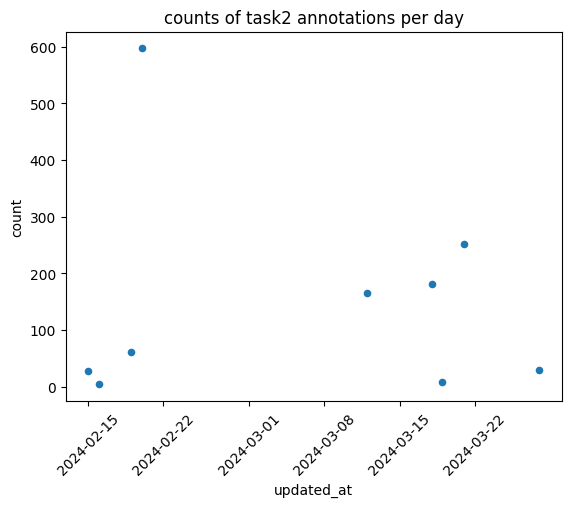

In [119]:
import matplotlib.pyplot as plt

# unseen days are 0
taskdf.plot(x="updated_at", y="count", kind="scatter")
# x axis rotate
plt.xticks(rotation=45)
plt.title("counts of task2 annotations per day")
# background to white
plt.gca().set_facecolor("white")
plt.show()

In [120]:
# add the model version
task2_model = task2.withColumn(
    "updated_at", F.col("updated_at").cast("timestamp")
).withColumn(
    "model_version",
    F.when(F.col("updated_at") < "2024-03-01", "v0").otherwise(
        F.when(F.col("updated_at") < "2024-03-21", "v1").otherwise("v2")
    ),
)
task2_model.groupBy("model_version").agg(
    F.countDistinct("unique_id"), F.count("*")
).orderBy("model_version").show()

+-------------+-------------------------+--------+
|model_version|count(DISTINCT unique_id)|count(1)|
+-------------+-------------------------+--------+
|           v0|                      691|    1926|
|           v1|                      357|     868|
|           v2|                      280|     679|
+-------------+-------------------------+--------+



In [140]:
(
    task2_model.groupBy("model_version")
    .pivot("origin")
    .count()
    .withColumnRenamed("prediction-changed", "prediction_changed")
    .join(task2_model.groupBy("model_version").count(), "model_version")
    .select(
        "model_version",
        "manual",
        F.col("prediction").alias("pred"),
        F.col("prediction_changed").alias("pred_changed"),
        F.expr("round(manual/count,2) as manual_ratio"),
        F.expr("round(prediction/count,2) as pred_ratio"),
        F.expr("round(prediction_changed/count,2) as pred_changed_ratio"),
    )
    .orderBy("model_version")
).show()

+-------------+------+----+------------+------------+----------+------------------+
|model_version|manual|pred|pred_changed|manual_ratio|pred_ratio|pred_changed_ratio|
+-------------+------+----+------------+------------+----------+------------------+
|           v0|   126|1262|         538|        0.07|      0.66|              0.28|
|           v1|    63| 481|         324|        0.07|      0.55|              0.37|
|           v2|    21| 456|         202|        0.03|      0.67|               0.3|
+-------------+------+----+------------+------------+----------+------------------+



In [154]:
(
    task2_model.where("completed_by = 1")
    .groupBy("model_version")
    .pivot("origin")
    .count()
    .withColumnRenamed("prediction-changed", "prediction_changed")
    .join(task2_model.groupBy("model_version").count(), "model_version")
    .select(
        "model_version",
        "manual",
        F.col("prediction").alias("pred"),
        F.col("prediction_changed").alias("pred_changed"),
        F.expr("round(manual/count,2) as manual_ratio"),
        F.expr("round(prediction/count,2) as pred_ratio"),
        F.expr("round(prediction_changed/count,2) as pred_changed_ratio"),
    )
    .orderBy("model_version")
).show()

+-------------+------+----+------------+------------+----------+------------------+
|model_version|manual|pred|pred_changed|manual_ratio|pred_ratio|pred_changed_ratio|
+-------------+------+----+------------+------------+----------+------------------+
|           v0|    65| 384|         161|        0.03|       0.2|              0.08|
|           v1|    36| 187|         148|        0.04|      0.22|              0.17|
|           v2|    21| 455|         202|        0.03|      0.67|               0.3|
+-------------+------+----+------------+------------+----------+------------------+



In [167]:
(
    task2_model.groupBy("model_version", "unique_id")
    .agg(F.first("lead_time").alias("lead_time"))
    .groupBy("model_version")
    .agg(
        F.round(F.avg("lead_time"), 2).alias("avg_lead_time"),
        F.round(F.stddev("lead_time"), 2).alias("std_lead_time"),
        F.median("lead_time").alias("median_lead_time"),
        F.max("lead_time").alias("max_lead_time"),
        F.count("*").alias("count"),
    )
    .orderBy("model_version")
    # get 95% confidence interval
    .withColumn(
        "ci95",
        F.expr(
            "round(std_lead_time * 1.96 / sqrt(count), 2)"
        ),  # 1.96 for 95% confidence
    )
    .select("model_version", "avg_lead_time", "ci95", "median_lead_time")
).show()

+-------------+-------------+----+----------------+
|model_version|avg_lead_time|ci95|median_lead_time|
+-------------+-------------+----+----------------+
|           v0|         9.66|0.73|           6.217|
|           v1|        15.89|2.07|          10.436|
|           v2|        10.13|1.26|          6.9475|
+-------------+-------------+----+----------------+



In [163]:
(
    task2_model.where("completed_by = 1")
    .groupBy("model_version", "unique_id")
    .agg(F.first("lead_time").alias("lead_time"))
    .groupBy("model_version")
    .agg(
        F.round(F.avg("lead_time"), 2).alias("avg_lead_time"),
        F.round(F.stddev("lead_time"), 2).alias("std_lead_time"),
        F.median("lead_time").alias("median_lead_time"),
        F.max("lead_time").alias("max_lead_time"),
    )
    .orderBy("model_version")
    .select("model_version", "avg_lead_time", "median_lead_time")
).show()

+-------------+-------------+----------------+
|model_version|avg_lead_time|median_lead_time|
+-------------+-------------+----------------+
|           v0|        12.21|           7.803|
|           v1|        19.44|          11.729|
|           v2|         10.1|           6.928|
+-------------+-------------+----------------+



In [145]:
# exploding excludes the results where there are no predictions
(
    task2_model.groupBy("model_version", "unique_id")
    .agg(F.count("*").alias("n"))
    .groupBy("model_version", "n")
    .count()
    .orderBy("model_version", "n")
).show()

+-------------+---+-----+
|model_version|  n|count|
+-------------+---+-----+
|           v0|  1|   57|
|           v0|  2|   46|
|           v0|  3|  575|
|           v0|  4|   13|
|           v1|  1|   91|
|           v1|  2|   24|
|           v1|  3|  239|
|           v1|  4|    3|
|           v2|  1|   70|
|           v2|  2|   23|
|           v2|  3|  185|
|           v2|  4|    2|
+-------------+---+-----+

